In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [3]:
engine.execute("USE sakila")

In [6]:
query = '''select name, title, rental_duration, rental_rate, length, replacement_cost, rating, special_features
from film_category
join category using (category_id)
join film using (film_id)
where category_id in (15,9,8,6)
;'''


In [7]:
data = pd.read_sql_query(query, engine)
data

,name,title,rental_duration,rental_rate,length,replacement_cost,rating,special_features
0,Documentary,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes"
1,Documentary,ADAPTATION HOLES,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes"
2,Documentary,ARMY FLINTSTONES,4,0.99,148,22.99,R,"Trailers,Commentaries"
3,Documentary,BEACH HEARTBREAKERS,6,2.99,122,16.99,G,"Deleted Scenes,Behind the Scenes"
4,Documentary,BED HIGHBALL,5,2.99,106,23.99,NC-17,"Trailers,Commentaries,Deleted Scenes"
...,...,...,...,...,...,...,...,...
279,Sports,TIGHTS DAWN,5,0.99,172,14.99,R,"Trailers,Behind the Scenes"
280,Sports,TOURIST PELICAN,4,4.99,152,18.99,PG-13,Deleted Scenes
281,Sports,TRADING PINOCCHIO,6,4.99,170,22.99,PG,"Trailers,Deleted Scenes,Behind the Scenes"
282,Sports,TUXEDO MILE,3,2.99,152,24.99,R,"Commentaries,Deleted Scenes,Behind the Scenes"


**In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it. Let's explore and use the data !**

In [10]:
data.dtypes

name                 object
title                object
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
special_features     object
dtype: object

In [11]:
data.isna().sum()

name                0
title               0
rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
special_features    0
dtype: int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              284 non-null    object 
 1   title             284 non-null    object 
 2   rental_duration   284 non-null    int64  
 3   rental_rate       284 non-null    float64
 4   length            284 non-null    int64  
 5   replacement_cost  284 non-null    float64
 6   rating            284 non-null    object 
 7   special_features  284 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 17.9+ KB


In [14]:
num=data.select_dtypes(np.number)

C:\Users\Gladys\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


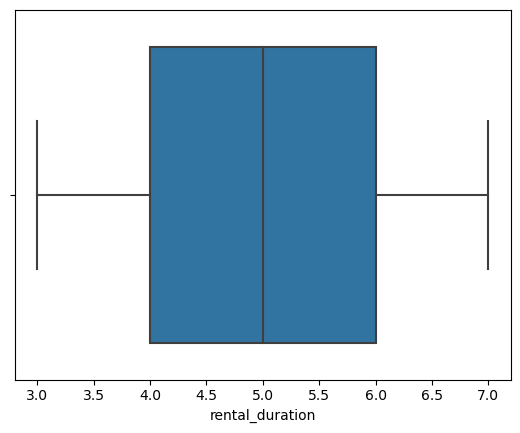

C:\Users\Gladys\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


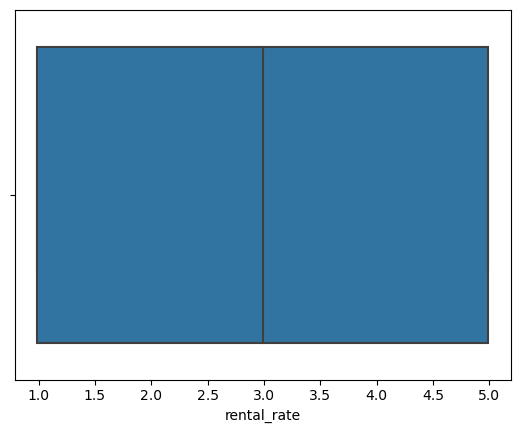

C:\Users\Gladys\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


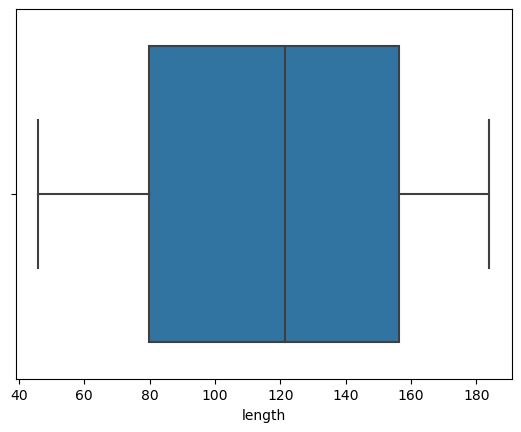

C:\Users\Gladys\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


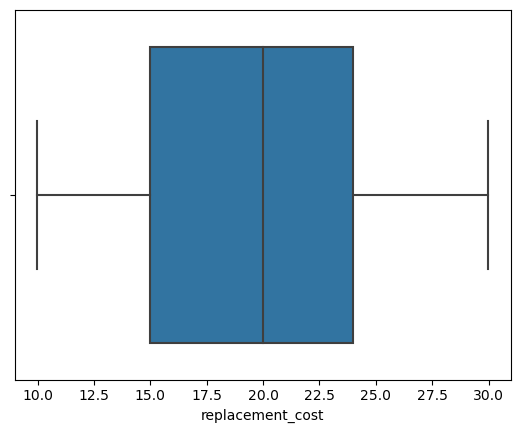

In [15]:
for i in num.columns:
    sns.boxplot(num[i])
    plt.show() #to check for outliers

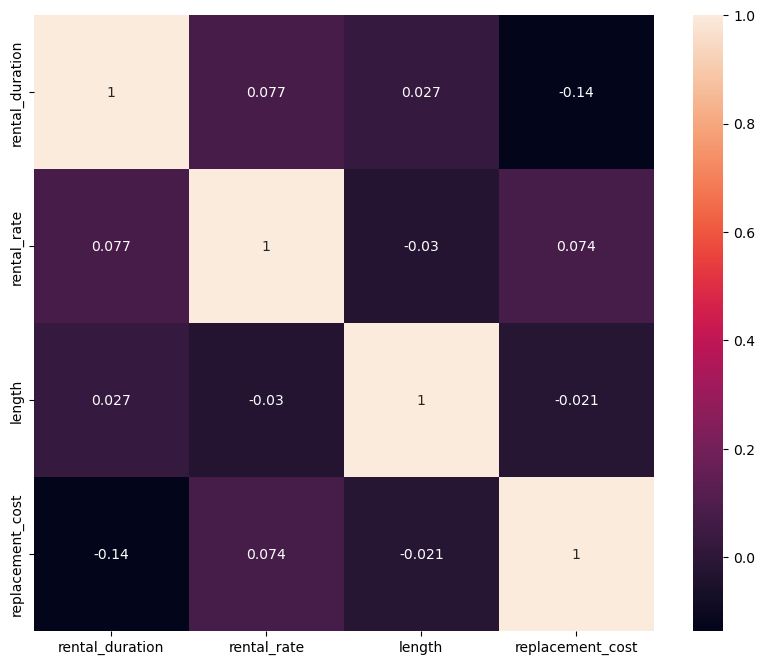

In [16]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [17]:
# Normalizing data
transformer = Normalizer().fit(num)
num_normalized = transformer.transform(num)
x = pd.DataFrame(num_normalized, columns=num.columns)

In [18]:
transformer = StandardScaler().fit(num)
xstandardized=transformer.transform(num)
xstandardized=pd.DataFrame(xstandardized)

In [19]:
cat = data.select_dtypes(include = np.object)
cat = cat.drop(['name'], axis=1)
cat = cat.drop(['title'], axis=1)
categorical = pd.get_dummies(cat, columns=['rating', 'special_features'])

C:\Users\Gladys\AppData\Local\Temp\ipykernel_15196\723970223.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat = data.select_dtypes(include = np.object)


In [20]:
y = data['name']
X = pd.DataFrame(np.concatenate((xstandardized, categorical), axis=1))

In [21]:
#categorical
X.columns=x.columns.append(categorical.columns)

In [22]:
X

,rental_duration,rental_rate,length,replacement_cost,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R,special_features_Behind the Scenes,...,special_features_Deleted Scenes,"special_features_Deleted Scenes,Behind the Scenes",special_features_Trailers,"special_features_Trailers,Behind the Scenes","special_features_Trailers,Commentaries","special_features_Trailers,Commentaries,Behind the Scenes","special_features_Trailers,Commentaries,Deleted Scenes","special_features_Trailers,Commentaries,Deleted Scenes,Behind the Scenes","special_features_Trailers,Deleted Scenes","special_features_Trailers,Deleted Scenes,Behind the Scenes"
0,0.764395,-1.193291,-0.773018,0.234136,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.485619,0.043551,-1.626326,-0.102546,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.678052,-1.193291,0.696567,0.570819,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.764395,0.043551,0.080290,-0.439228,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.043172,0.043551,-0.298958,0.739160,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,0.043172,-1.193291,1.265439,-0.775910,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
280,-0.678052,1.280393,0.791379,-0.102546,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281,0.764395,1.280393,1.218033,0.570819,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
282,-1.399275,0.043551,0.791379,0.907501,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [24]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [25]:
classification.score(X_test, y_test)

0.22807017543859648

In [26]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.22807017543859648

In [27]:
accuracy_score(y_test, predictions)

0.22807017543859648

In [28]:
pd.Series(predictions).value_counts()

Documentary    21
Foreign        19
Sports          9
Family          8
dtype: int64

In [29]:
y_test

179        Foreign
132         Family
234         Sports
69          Family
191        Foreign
154        Foreign
216         Sports
64     Documentary
177        Foreign
268         Sports
250         Sports
281         Sports
60     Documentary
189        Foreign
255         Sports
269         Sports
243         Sports
260         Sports
220         Sports
117         Family
59     Documentary
161        Foreign
201        Foreign
197        Foreign
128         Family
110         Family
99          Family
46     Documentary
41     Documentary
224         Sports
249         Sports
1      Documentary
23     Documentary
253         Sports
108         Family
159        Foreign
98          Family
171        Foreign
144        Foreign
246         Sports
103         Family
182        Foreign
262         Sports
232         Sports
40     Documentary
112         Family
32     Documentary
239         Sports
75          Family
124         Family
85          Family
136         Family
186        F

In [30]:
predictions[:10]

array(['Foreign', 'Family', 'Foreign', 'Sports', 'Documentary', 'Foreign',
       'Documentary', 'Documentary', 'Documentary', 'Foreign'],
      dtype=object)

[[4 2 3 2]
 [4 2 5 3]
 [7 1 4 1]
 [6 3 7 3]]


C:\Users\Gladys\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


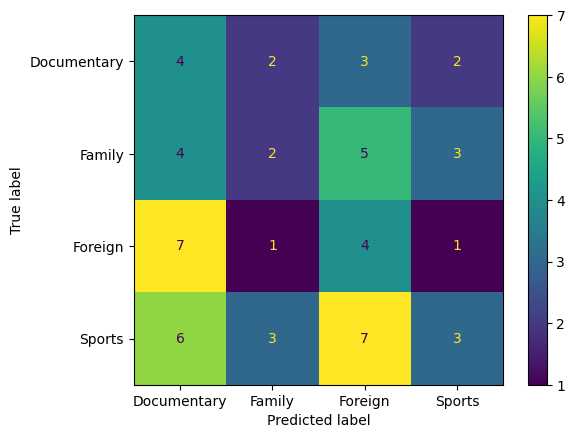

In [32]:
#got A LOT if not all help from stack overflow
from sklearn.metrics import plot_confusion_matrix
print(confusion_matrix(y_test, predictions))
plot_confusion_matrix(classification, X_test, y_test)  
plt.show() 

In [33]:
classification.predict_proba(X_test)

array([[0.2656871 , 0.21395258, 0.31415658, 0.20620374],
       [0.30865594, 0.32661369, 0.16957462, 0.19515574],
       [0.21508545, 0.24762229, 0.27979481, 0.25749745],
       [0.25476595, 0.21244337, 0.19953313, 0.33325755],
       [0.33344139, 0.28863532, 0.22123868, 0.15668461],
       [0.12112747, 0.07858267, 0.51924902, 0.28104084],
       [0.34624786, 0.20020143, 0.13612208, 0.31742862],
       [0.40110235, 0.26139799, 0.16649081, 0.17100885],
       [0.49195033, 0.14880796, 0.22723912, 0.13200258],
       [0.21972935, 0.16854378, 0.3152249 , 0.29650197],
       [0.21340011, 0.08674627, 0.53900816, 0.16084546],
       [0.05638488, 0.53496583, 0.18062427, 0.22802501],
       [0.20066785, 0.24515098, 0.28968898, 0.26449219],
       [0.05560184, 0.42446991, 0.21725241, 0.30267584],
       [0.26586804, 0.42772666, 0.18220204, 0.12420325],
       [0.26974078, 0.12821936, 0.36317993, 0.23885992],
       [0.4316489 , 0.14788286, 0.11214234, 0.30832589],
       [0.09691909, 0.15954925,

In [34]:
classification.predict_proba(X_test)[::,0]

array([0.2656871 , 0.30865594, 0.21508545, 0.25476595, 0.33344139,
       0.12112747, 0.34624786, 0.40110235, 0.49195033, 0.21972935,
       0.21340011, 0.05638488, 0.20066785, 0.05560184, 0.26586804,
       0.26974078, 0.4316489 , 0.09691909, 0.49959222, 0.34904065,
       0.1864828 , 0.54589366, 0.20597122, 0.35786987, 0.34032575,
       0.03689034, 0.20766722, 0.22684113, 0.1912458 , 0.07485314,
       0.29805173, 0.18618342, 0.26589317, 0.50194775, 0.16182024,
       0.42669472, 0.18738738, 0.0615787 , 0.30629826, 0.47012095,
       0.10834999, 0.28887214, 0.24396301, 0.41781979, 0.31565644,
       0.32694971, 0.25543529, 0.03851348, 0.19411662, 0.71096972,
       0.28425577, 0.03650277, 0.45701193, 0.23818855, 0.53761967,
       0.43368408, 0.16517316])